# Practical Part: Neural Network Implementation & Experiments

Team:
* Jonathan Bhimani-Burrows ()
* Arlie Coles (20121051)
* Yue (Violet) Guo (20120727)

Load the Fashion MNIST data:
Note: keep your file structures like this for reading input data without
using ```import os``` for path change!
```
./Homework 3
├── 3_practical_part.ipynb
├── circles.txt
├── data
│   ├── fashion
│   │   ├── t10k-images-idx3-ubyte.gz
│   │   ├── t10k-labels-idx1-ubyte.gz
│   │   ├── train-images-idx3-ubyte.gz
│   │   └── train-labels-idx1-ubyte.gz
│   └── mnist
│       └── README.md
├── hw3
│   └── d3english.pdf
├── overleaf_url.txt
└── utils
    ├── __init__.py
    ├── __pycache__
    │   ├── __init__.cpython-36.pyc
    │   └── mnist_reader.cpython-36.pyc
    ├── argparser.py
    ├── helper.py
    └── mnist_reader.py
```

In [1]:
import utils.mnist_reader as mnist_reader
import numpy as np
import math
import copy 
import matplotlib.pyplot as plt
import time

In [30]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_valid = X_test[0:5000]
y_valid = y_test[0:5000]
X_test = X_test[5000:10000]
y_test = y_test[5000:10000]
print(y_test.shape)

(5000,)


Load the Circles data:

In [3]:
circlesData = np.loadtxt(open('circles.txt','r'))
circlesTarget = circlesData[:,2]
circlesData = circlesData[:,[0,1]] 
#circlesData = circlesData
#circlesData = np.expand_dims(circlesData, axis = 1)
#circlesData = circlesData.reshape(1100, 2, 1)
print(circlesData.shape)
circlesTarget = np.array([int(i) for i in circlesTarget])
print(circlesTarget)

(1100, 2)
[1 1 0 ... 0 1 1]


In [32]:
class loadData:
    def __init__(self, data_type = 'circles'):
        self.addOnes = False
        self.data_path = '/data/'
    
    def convertTarget(self, targetValues):
        # Convert to one-hot encoding
        numClasses = np.max(targetValues) + 1
        return np.eye(numClasses)[targetValues]
    

    def loadNumData(self, data, target):
        # Split into train/validation/test
        
        np.random.seed(6390)
        randIndices = np.random.permutation(data.shape[0])
        data, target = data[randIndices], target[randIndices]
        
        div1 = int(math.floor(0.8 * data.shape[0]))
        div2 = int(math.floor(0.9 * data.shape[0]))
        trainData, trainTarget = data[:div1], target[:div1]
        validData, validTarget = data[div1:div2], target[div1:div2]
        testData, testTarget = data[div2:], target[div2:]
    
        # Get one hot encoding
        trainTarget = self.convertTarget(trainTarget)
        validTarget = self.convertTarget(validTarget)
        testTarget = self.convertTarget(testTarget)
        
        return trainData, trainTarget, validData, validTarget, testData, testTarget

dataLoader = loadData()
 
trainData, trainTarget, validData, validTarget, testData, testTarget = dataLoader.loadNumData(circlesData, circlesTarget)


#y_train = np.expand_dims(y_train, axis = 1)
y_train =  np.array([int(i) for i in y_train])
y_train = loadData().convertTarget(y_train)
y_test =  np.array([int(i) for i in y_test])
y_test = loadData().convertTarget(y_test)
y_valid =  np.array([int(i) for i in y_valid])
y_valid = loadData().convertTarget(y_valid)

print(y_valid.shape)
print(y_train.shape)
print(y_test.shape)

TypeError: only size-1 arrays can be converted to Python scalars

## Experiments

### Part 1

> As a beginning, start with an implementation that computes the gradients for a single example, and check that the gradient is correct using the finite difference method described above.

In [5]:
class BatchSampler(object):
    '''
    randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def get_batch(self, K = None):
        '''
        Get a random batch without replacement 
        '''
        
        if not K:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.arange(K)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch
    
        

In [6]:
# Our own activation functions

def relu(pre_activation):
    '''
    preactivation is a vector
    '''
    relu_output = np.zeros(pre_activation.shape)
    relu_flat = relu_output.flatten()
    for i, neuron in enumerate(pre_activation.flatten()):
        if neuron > 0:
            relu_flat[i] = neuron
    relu_output = relu_flat.reshape(pre_activation.shape)
    return relu_output

def softmax_single(pre_activation):
    '''
    Numerically stable because subtracting the max value makes bit overflow impossible,
    we will only have non-positive values in the vector
    '''
    exps = np.exp(pre_activation - np.max(pre_activation))
    return exps / np.sum(exps)

def softmax_multiple(pre_activation):
    '''
    Numerically stable because subtracting the max value makes bit overflow impossible,
    we will only have non-positive values in the vector
    '''
    exps = np.exp(pre_activation - np.max(pre_activation, axis = 0))
    return exps / np.sum(exps, axis = 0)

In [7]:
w1_fixed = np.array([[ 0.20960823 , 0.13663559], [ 0.38623373, -0.32807251] ,[-0.63849439 , 0.0131154 ],
                     [ 0.5142807 ,  0.0595152 ], [-0.31075243 , 0.52335846]])
w2_fixed = np.array( [[ 0.06159592, -0.10424877,  0.23591191 , 0.06177611 , 0.42799154],
                      [ 0.40780062,  0.0759027  , 0.09284926, -0.14837115 ,  0.16844463]])

In [74]:
def classErr(target, predicted):
    cnt = 0
    for i in range(target.shape[0]):
        if target[i] != predicted [i]:
            cnt +=1
    return float(cnt) / target.shape[0]

In [80]:
class neuralNet():
    def __init__(self, d, dh, m, n, eta=3e-4, regularize=None, fixed=False):
        self.inputDim = d #inputDim
        self.hiddenDim = dh #hiddenDim
        self.outputDim = m #outputDim
        self.regularize = regularize # lambda value
        self.learningRate = eta
        self.numData = n
        self.batchErrorGradients = []
        self.regularize = regularize
        #may use xavier init - maybe explore this later.
        
        # Initial weights and biases
        if fixed:
            self.W_1 = w1_fixed
            self.W_2 = w2_fixed
        else:
            self.W_1 = np.random.uniform(-1/np.sqrt(d), 1/np.sqrt(d), dh*d).reshape(dh, d)
            self.W_2 = np.random.uniform(-1/np.sqrt(dh), 1/np.sqrt(dh), dh*m).reshape(m, dh) 
        
        self.b_1 = np.zeros(dh).reshape(dh,)
        self.b_2 = np.zeros(m).reshape(m,)


    def fprop(self, batchData, mode='matrix'):
        if mode == 'matrix':
            #print('self.b1', self.b_1.shape)
            #print('self.W_1', self.W_1.shape)
            #print('batchData.T', batchData.T.shape)
            stack_b1 = np.array([self.b_1,] * self.numData).T
            #print('stack_b1', stack_b1.shape)
            self.h_a = np.dot(self.W_1, batchData.T) + stack_b1
        elif mode == 'loop':
            self.h_a = np.dot(self.W_1, batchData.T) + self.b_1
            

        self.h_s = relu(self.h_a)
        
        if mode == 'matrix':
            stack_b2 = np.array([self.b_2,] * self.numData).T
            self.o_a = np.dot(self.W_2, self.h_s) + stack_b2
        elif mode == 'loop':
            self.o_a = np.dot(self.W_2, self.h_s) + self.b_2
        
        if batchData.shape[0] == 1:
            print('using single softmax')
            self.o_s = softmax_single(self.o_a)
        else:
            self.o_s = softmax_multiple(self.o_a)
        
        if mode == 'loop':
            self.prediction = np.argmax(self.o_s,axis = 0)
        elif mode == 'matrix':
            self.prediction = np.argmax(self.o_s,axis = 0)
        
    def errorRate(self, y, mode='matrix'):
        '''
        negative log
        -logO_s(x)
        '''        
        
        if mode == 'loop':
            negLog = -self.o_a[np.argmax(y)] + np.log(np.sum(np.exp(self.o_a), axis=0))
            
        elif mode == 'matrix':
            negLog = []
            #print("shape y from error rate class ", y.shape)
            #print("shape self.o_a from error rate class ", self.o_a.shape)
            for i in range(y.shape[1]):
                #print("y shape ", y.shape)
                #print("y[:,i] ", y[:,i])
                #print("np.argmax(y[:,i]) ", np.argmax(y[:,i]))
                #print('-self.o_a[np.argmax(y[:,i])]', -self.o_a[np.argmax(y[:,i])])
                error_at_point = -self.o_a[np.argmax(y[:,i])][i] + np.log(np.sum(np.exp(self.o_a), axis=0))[i]
                negLog.append(error_at_point)
            negLog = np.array(negLog)
            #print("in error rate class def ", negLog[0])
            negLog = np.mean(negLog)

        return negLog
          
    def bpropLoop(self, batchData, batchTarget):
        self.grad_oa = self.o_s - batchTarget
        self.grad_W2 = np.outer(self.grad_oa, self.h_s.T)
        self.grad_b2 = self.grad_oa
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        self.grad_W1 = np.outer(self.grad_ha, batchData)
        self.grad_b1 = self.grad_ha
        
    def bprop_matrix(self, batchData, batchTarget):
        self.grad_oa = self.o_s - batchTarget
        self.grad_W2 = np.matmul(self.grad_oa, self.h_s.T)/batchData.shape[0] #!
        self.grad_b2 = np.sum(self.grad_oa, axis=1)/batchData.shape[0] #!
        self.grad_hs = np.matmul(self.W_2.T, self.grad_oa)
        self.grad_ha = np.multiply(self.grad_hs, np.where(self.h_a > 0, 1.0, 0.0))
        self.grad_W1 = np.matmul(self.grad_ha, batchData)/batchData.shape[0] #!
        self.grad_b1 = np.sum(self.grad_ha, axis=1)/batchData.shape[0] #!
        
    def bprop(self, batchData, batchTarget, mode='matrix'):
        '''
        batchTarget already in one-hot format
        '''
        
        #batch target must be m by n
        self.grad_oa = self.o_s - batchTarget
        i = 0
        self.grad_W2 = [np.outer(self.grad_oa[:,i], self.h_s[:,i].T) for i in range(batchData.shape[0])]
        self.grad_b2 = self.grad_oa #np.mean(self.grad_oa, axis = 1)
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        # Check this (dim mismatch maybe)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        #self.grad_W1 = [np.outer(self.grad_ha[:,i], batchData[i]) for i in range(self.numData)]
        self.grad_W1 = [np.outer(self.grad_ha[:,i], batchData[i]) for i in range(batchData.shape[0])]
        # temporary hack for grad_W
        self.grad_b1 = self.grad_ha
        #print("")
        #print("***********************")
        #print("b1 before avg", self.grad_b1)
        #print("b2 before avg", self.grad_b2)
        
        if mode == 'matrix':
            self.grad_W2 = np.mean(np.array(self.grad_W2), axis=0)
            self.grad_b2 = np.mean(np.array(self.grad_b2), axis=1)
            
            self.grad_W1 = np.mean(np.array(self.grad_W1), axis=0)
            self.grad_b1 = np.mean(np.array(self.grad_b1), axis=1)
            #print("")
            #print("***********************")

            #print("b1 after avg", self.grad_b1)
            #print("b2 after avg", self.grad_b2)
        

        
    def updateParams(self):
        if self.regularize:
            self.W_1 -= (self.regularize[0] * np.sign(self.W_1) + 2 * self.regularize[1] * self.W_1) * self.learningRate
            self.W_2 -= (self.regularize[2] * np.sign(self.W_2) + 2 * self.regularize[3] * self.W_2) * self.learningRate
        
        self.W_1 -= self.grad_W1 * self.learningRate
        self.W_2 -= self.grad_W2 * self.learningRate
        self.b_1 -= self.grad_b1 * self.learningRate
        self.b_2 -= self.grad_b2 * self.learningRate
            
        
    
    
    def gradDescentLoop(self, batchData, batchTarget, K):
        # Call each example in the data (over the minibatches) in a loop
        grad_W2, grad_b2, grad_W1, grad_b1 = [], [], [], []
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i], mode='loop') #batchTarget[:,i]
            self.bpropLoop(batchData[i],np.array(batchTarget[:,i]))
            predBatch.append(self.prediction)
            grad_W2.append(self.grad_W2)
            grad_b2.append(self.grad_b2)
            grad_W1.append(self.grad_W1)
            grad_b1.append(self.grad_b1)
        self.grad_W2 = np.mean(grad_W2, axis=0)
        self.grad_b2 = np.mean(grad_b2, axis=0)
        self.grad_W1 = np.mean(grad_W1, axis=0)
        self.grad_b1 = np.mean(grad_b1, axis=0)
        
        # Update params
        #self.updateParams()
    
    def fpropLoop(self, batchData, K):
        '''
        unlike the above def gradDescentLoop(self, batchData, batchTarget, K)
        this function only runs batchData (this is usually in test phase)
        through the forward prop, without calculating any gradient update rule.
        
        Use to get predictions
        
        batchData: more like test/val data
        K: ALWAYS == batchData.shape[0]
        
        '''
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i], mode='loop') #batchTarget[:,i]
            predBatch.append(self.prediction)
        self.predBatch = np.array(predBatch)    
        
    def gradDescentMat(self, batchData, batchTarget):
        # Feed the entire data matrix in as input
        self.fprop(batchData)
        #self.bprop(batchData, batchTarget)
        if batchData.shape[0] == 1:
            self.bprop(batchData, batchTarget)
        else:
            self.bprop_matrix(batchData, batchTarget)
        
        

            
'''      
def earlyStopping(net):
    totalEpoch = 10 #may not be enough??
    for each epoch
        train
        valid
        test
        plot / print errors
'''




'      \ndef earlyStopping(net):\n    totalEpoch = 10 #may not be enough??\n    for each epoch\n        train\n        valid\n        test\n        plot / print errors\n'

### Part 2

> Display  the  gradients  for  both  methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a single example.

In [10]:
# Direct computation
nn = neuralNet(2, 2, 2, 1)
nn.fprop(trainData[0:1], mode='loop')
nn.bpropLoop(trainData[0:1], trainTarget[0:1])
oldErr = nn.errorRate(trainTarget[0:1], mode='loop')
print('Grad W2:\n', nn.grad_W2)
print('Grad b2:\n', nn.grad_b2)
print('Grad W1:\n', nn.grad_W1)
print('Grad b1:\n', nn.grad_b1)

using single softmax
Grad W2:
 [[-0.26394183 -0.07455755 -0.26394183 -0.07455755]
 [ 0.07130529  0.02014212  0.07130529  0.02014212]
 [-0.23892885 -0.06749195 -0.23892885 -0.06749195]
 [ 0.09631827  0.02720772  0.09631827  0.02720772]]
Grad b2:
 [[-0.78730529  0.21269471]
 [-0.71269471  0.28730529]]
Grad W1:
 [[-0.02326689  0.01571521]
 [ 0.04412648 -0.02980445]
 [ 0.19201408 -0.12969252]
 [-0.0618842   0.04179859]]
Grad b1:
 [[-0.02807696  0.05324896]
 [ 0.23171007 -0.07467782]]


In [11]:
# Finite difference
nn_debug = copy.deepcopy(nn)
sigma = 1e-5

# W1 - perturb all 4 elements
nn_debug.W_1[0][0] += sigma
nn_debug.fprop(trainData[0:1], mode='loop')
newErr = nn_debug.errorRate(trainTarget[0:1], mode='loop')

print("old err\n", oldErr)
print("newErr \n", newErr)
estimate = (oldErr - newErr) / sigma
ratio = nn.grad_W1[0][0] / estimate
print('Perturbing an element of W1. Ratio:\n', ratio)


using single softmax
old err
 [0.85475024 0.85475024]
newErr 
 [0.85475444 0.85475444]
Perturbing an element of W1. Ratio:
 [0.05537575 0.05537575]


### Part 3

> Add a hyperparameter for the minibatch size $K$ to allow computing the gradients on a minibatch of $K$ examples (in a matrix), by looping over the $K$ examples (this is a small addition to your previous code).

### Part 4

> Display the gradients for both methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a minibatch with 10 examples (you can use examples from both classes from the two circles dataset).

### Part 5

> Train your neural network using gradient descent on the two circles dataset. Plot the decision regions for several different values of the hyperparameters (weight decay, number of hidden units, early stopping) so as to illustrate their effect on the capacity of the model.

We plot the circle training dataset to get an idea of what our classifier needs to learn:

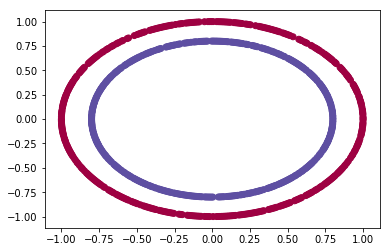

In [12]:
# plot the circle training dataset
plotTrainTarget = np.argmax(trainTarget, axis = 1)
plt.scatter(trainData[:,0], trainData[:,1], c=plotTrainTarget, cmap=plt.cm.Spectral)

Our training function(s):

In [78]:
def show_error(nn, epoch, train, valid, test):
    # Train
    nn.numData = train[0].shape[0]

    nn.fprop(train[0], mode='matrix')
    training_loss = nn.errorRate(train[1].T, mode='matrix')
    training_err = classErr(np.argmax(train[1], axis = 1), nn.prediction)
    
    # Valid
    nn.numData = valid[0].shape[0]
    nn.fprop(valid[0], mode='matrix') 

    valid_loss = nn.errorRate(valid[1].T, mode='matrix')
    valid_err = classErr(np.argmax(valid[1], axis  =1 ), nn.prediction)
    
    # Test
    nn.numData = test[0].shape[0]

    nn.fprop(test[0], mode='matrix') 
    test_loss = nn.errorRate(test[1].T, mode='matrix')
    test_err = classErr(np.argmax(test[1], axis = 1), nn.prediction)
    
    # Write to log file
    with open('errors.txt', 'a+') as fp:
        line = '{},{},{},{},{},{},{}\n'.format(epoch, training_loss, training_err, 
                                             valid_loss, valid_err, test_loss, test_err)
        fp.write(line)

In [66]:
def train_loop(nn, data, target,  K, num_epoch, fixed = False): 
    '''
    train minibtaches over K epochs (in a loop)
    also does prediction and error calcualation
    '''
    # Get minibatch
    batchSampler = BatchSampler(data, target, K)
    numBatch = data.shape[0] // K 
    # training loop
    for n in range(num_epoch):
        # Do descent and update params - this is one epoch
        for i in range(numBatch):
            if fixed:
                batchData, batchTarget = batchSampler.get_batch(K)
            elif not fixed:
                batchData, batchTarget = batchSampler.get_batch()
            #difference: another loop here
            nn.gradDescentLoop(batchData, batchTarget.T, K)
            nn.updateParams()
        if n % 100 == 0:
            nn.fpropLoop(data, data.shape[0]) 
            print("Cross-entropy loss at the end of epoch {}: {}".format(n, nn.errorRate(target.T, mode = 'loop')))
            print("classification error at the end of epoch {}: {}".format(n,
                                                    classErr(np.argmax(target, axis = 1), nn.predBatch)))        
    
    # finalized weights, need to fprop and get the error rate 
    # a for loop inside the prop for each elem
    nn.fpropLoop(data, data.shape[0]) 
    print("End of train loop process.")


def train_matrix(nn, data, target, K, num_epoch, fixed=False, valid=None, test=None):
    # Get minibatch
    batchSampler = BatchSampler(data, target, K)
    numBatch = data.shape[0] // K 
    for n in range(num_epoch):
        # Do descent and update params - this is one epoch
        for i in range(numBatch):
            if fixed:
                batchData, batchTarget = batchSampler.get_batch(K)
            elif not fixed:
                batchData, batchTarget = batchSampler.get_batch()
            nn.numData = K
            nn.gradDescentMat(batchData, batchTarget.T)
            #print(nn.grad_W2)
            nn.updateParams()
        if n % 100 == 0:
            print(':)')
            #nn.fprop(batchData, mode = 'matrix') 
            #pred = np.argmax(nn.o_s, axis = 0)
            #print("Cross-entropy loss at the end of epoch {}: {}".format(n, nn.errorRate(batchTarget.T, mode = 'matrix')))
            #print("classification error at the end of epoch {}: {}".format(n,
            #                                        classErr(np.argmax(batchTarget, axis = 1), pred ))) 
        if valid:
            nn.numData = valid[0].shape[0]
            show_error(nn, n, [data, target], valid, test)
    print("End of train matrix process.")


Functions to plot the decision boundary and decision regions:

In [14]:
def plot_decision_boundary(nn, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h betweethem
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    
    newData =np.c_[xx.ravel(), yy.ravel()]
    
    nn.fpropLoop(newData, newData.shape[0])
    Z = nn.predBatch
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def plotDecision(nn, data):
    nn.fpropLoop(data, data.shape[0])
    plt.scatter(data[:,0], data[:,1], c = nn.predBatch)
    plt.show()

We vary the number of hidden units:

Cross-entropy loss at the end of epoch 0: 0.681185694001535
classification error at the end of epoch 0: 0.5
End of train matrix process.
Plotting the decision boundary for number of hidden units = 2.


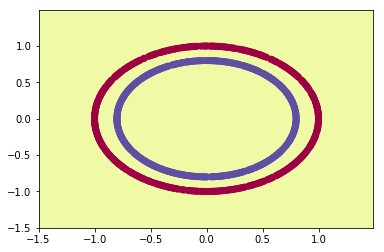

Cross-entropy loss at the end of epoch 0: 0.6589338224890479
classification error at the end of epoch 0: 0.4
End of train matrix process.
Plotting the decision boundary for number of hidden units = 50.


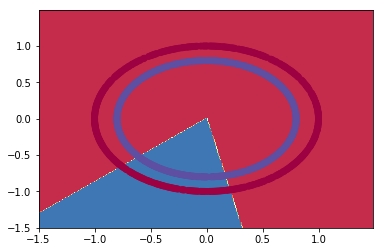

Cross-entropy loss at the end of epoch 0: 0.7070415359448551
classification error at the end of epoch 0: 0.5
End of train matrix process.
Plotting the decision boundary for number of hidden units = 100.


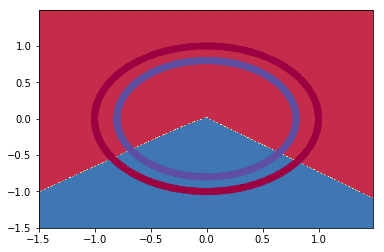

In [15]:
# Train on circles, varying number of hidden units
# K is Size of batches
K = 10

num_hidden = [2,50,100]
for hidden in num_hidden:
    circleNet = neuralNet(2, hidden, 2, K) 
    #train_loop(circleNet, trainData, trainTarget, K, 1)
    train_matrix(circleNet, trainData, trainTarget, K, 1)
    print('Plotting the decision boundary for number of hidden units = {}.'.format(hidden))
    plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))

Next we vary the number of epochs (looking at the error on the validation set would allow us to "early stop" at the point where the validation error is at its lowest):

Cross-entropy loss at the end of epoch 0: 0.9302756344363425
classification error at the end of epoch 0: 0.4965909090909091
End of train loop process.


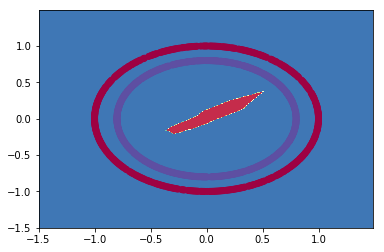

Plotting the decision boundary for number of epochs = 10.
Cross-entropy loss at the end of epoch 0: 0.6719623565049195
classification error at the end of epoch 0: 0.49886363636363634
End of train loop process.


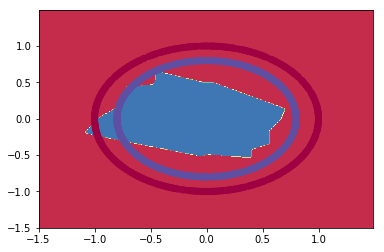

Plotting the decision boundary for number of epochs = 100.
Cross-entropy loss at the end of epoch 0: 0.6596660679907057
classification error at the end of epoch 0: 0.4965909090909091
Cross-entropy loss at the end of epoch 100: 0.6638344346737738
classification error at the end of epoch 100: 0.4875
Cross-entropy loss at the end of epoch 200: 0.6822327316856945
classification error at the end of epoch 200: 0.4738636363636364
Cross-entropy loss at the end of epoch 300: 0.7079630532593023
classification error at the end of epoch 300: 0.38522727272727275
Cross-entropy loss at the end of epoch 400: 0.7240367274440849
classification error at the end of epoch 400: 0.38636363636363635
Cross-entropy loss at the end of epoch 500: 0.7400327892722005
classification error at the end of epoch 500: 0.3443181818181818
Cross-entropy loss at the end of epoch 600: 0.7507375692293337
classification error at the end of epoch 600: 0.33181818181818185
Cross-entropy loss at the end of epoch 700: 0.765212203116

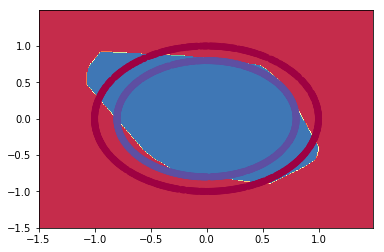

Plotting the decision boundary for number of epochs = 1000.


In [16]:
num_epoch = [10, 100, 1000]    
for n in num_epoch:
    circleNet = neuralNet(2, 15, 2, trainData.shape[0] ) # K = 2
    train_loop(circleNet, trainData, trainTarget, K, n)
    plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))
    print('Plotting the decision boundary for number of epochs = {}.'.format(n))
    #plotDecision(circleNet,testData)


Then we vary the amount of regularization (weight decay):

Cross-entropy loss at the end of epoch 0: 0.6940090251648422
classification error at the end of epoch 0: 0.5045454545454545
Cross-entropy loss at the end of epoch 100: 0.6845791498718461
classification error at the end of epoch 100: 0.4965909090909091
End of train loop process.
No regularization:


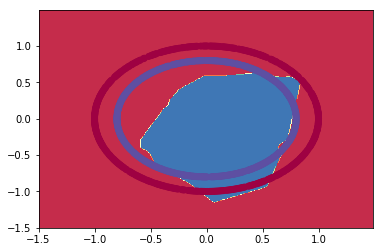

Cross-entropy loss at the end of epoch 0: 0.7139886027447911
classification error at the end of epoch 0: 0.49886363636363634
Cross-entropy loss at the end of epoch 100: 0.6260948661098971
classification error at the end of epoch 100: 0.5420454545454545
End of train loop process.
Regularization: [0.0003, 0.0003, 0.0003, 0.0003]


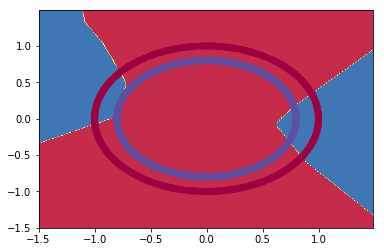

Cross-entropy loss at the end of epoch 0: 0.8623963639179131
classification error at the end of epoch 0: 0.4954545454545455
Cross-entropy loss at the end of epoch 100: 0.7110866049592806
classification error at the end of epoch 100: 0.4875
End of train loop process.
Regularization: [0.002, 0.002, 0.002, 0.002]


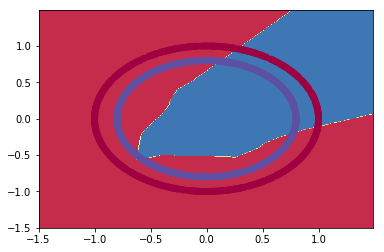

Cross-entropy loss at the end of epoch 0: 0.7799298133490662
classification error at the end of epoch 0: 0.5011363636363636
Cross-entropy loss at the end of epoch 100: 0.724304778517899
classification error at the end of epoch 100: 0.49204545454545456
End of train loop process.
Regularization: [0.02, 0.01, 0.02, 0.01]


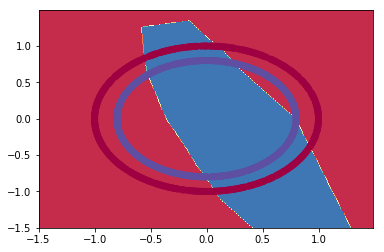

In [17]:
# No regularization
circleNet = neuralNet(2, 15, 2, trainData.shape[0]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 200) # 1000 epoches
print('No regularization:')
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))


# with regularization
circleNet = neuralNet(2, 15, 2, trainData.shape[0], regularize=[3e-4, 3e-4,  3e-4, 3e-4]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 200) # 1000 epoches
print('Regularization: {}'.format(circleNet.regularize))
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))


# with regularization
circleNet = neuralNet(2, 15, 2, trainData.shape[0], regularize=[2e-3, 2e-3,  2e-3, 2e-3]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 200) # 1000 epoches
print('Regularization: {}'.format(circleNet.regularize))
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))



# with different regularization
circleNet = neuralNet(2, 15, 2, trainData.shape[0], regularize=[2e-2, 1e-2,  2e-2, 1e-2]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 200) # 1000 epoches
print('Regularization: {}'.format(circleNet.regularize))
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))

### Part 6

> As a second step, copy your existing implementation to modify it to a new implementation that will use matrix calculus (instead of a loop) on batches of size $K$ to improve efficiency. **Take the matrix expressions in numpy derived in the first part, and adapt them for a minibatch of size $K$. Show in your report what you have modified (describe the former and new expressions with the shapes of each matrix).**

### Part 7

> Compare both implementations (with a loop and with matrix calculus) to check that they both give the same values for the gradients on the parameters, first for $K = 1$, then for $K = 10$. Display the gradients for both methods.

In [58]:
# Loop with K = 1
K = 1
test_net = neuralNet(2, 5, 2, K)
train_loop(test_net, trainData[0:1], trainTarget[0:1], K, 1, fixed = True)

print('Gradients for K = 1 for loop method')
print('grad_W1:', test_net.grad_W1)
print('grad_b1:', test_net.grad_b1)
print('grad_W2:', test_net.grad_W2)
print('grad_b2:', test_net.grad_b2)

print()
# Matrix with K = 1
K = 1
test_net = neuralNet(2, 5, 2, K)
train_matrix(test_net, np.array(trainData[0:1]).reshape(1, 2), trainTarget[0:1], K, 1, fixed = True)

print('Gradients for K = 1 for matrix method')
print('grad_W1:', test_net.grad_W1)
print('grad_b1:', test_net.grad_b1)
print('grad_W2:', test_net.grad_W2)
print('grad_b2:', test_net.grad_b2)

Cross-entropy loss at the end of epoch 0: 0.6695137368614306
classification error at the end of epoch 0: 0.0
End of train loop process.
Gradients for K = 1 for loop method
grad_W1: [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.00520811  0.00351772]
 [-0.06134575  0.0414349 ]]
grad_b1: [ 0.          0.          0.         -0.0062848  -0.07402805]
grad_W2: [[ 0.          0.          0.         -0.31477127 -0.12584893]
 [ 0.          0.          0.          0.31477127  0.12584893]]
grad_b2: [-0.48815271  0.48815271]

self.b1 (5,)
self.W_1 (5, 2)
batchData.T (2, 1)
stack_b1 (5, 1)
using single softmax
:)
End of train matrix process.
Gradients for K = 1 for matrix method
grad_W1: [[-0.10411774  0.07032449]
 [ 0.          0.        ]
 [ 0.22962109 -0.15509351]
 [ 0.          0.        ]
 [ 0.06389349 -0.04315573]]
grad_b1: [-0.1256425   0.          0.27709176  0.          0.0771025 ]
grad_W2: [[-0.25520888  0.         -0.24010958  0.         -0.2333796

In [19]:
# Loop with K = 10
K = 10
test_net = neuralNet(2, 5, 2, K, fixed=True)
train_loop(test_net, trainData[0:10], trainTarget[0:10], K, 1, fixed = True)

print('Gradients for K = 10 for matrix method')
print('grad_W1:', test_net.grad_W1)
print('grad_b1:', test_net.grad_b1)
print('grad_W2:', test_net.grad_W2)
print('grad_b2:', test_net.grad_b2)

print()
# Matrix with K = 10
K = 10
test_net = neuralNet(2, 5, 2, K, fixed=True)
train_matrix(test_net, trainData[0:10], trainTarget[0:10], K, 1, fixed = True)

print('Gradients for K = 10 with matrix method')
print('grad_W1:', test_net.grad_W1)
print('grad_b1:', test_net.grad_b1)
print('grad_W2:', test_net.grad_W2)
print('grad_b2:', test_net.grad_b2)

Cross-entropy loss at the end of epoch 0: 0.7050771988340923
classification error at the end of epoch 0: 0.9
End of train loop process.
Gradients for K = 10 for matrix method
grad_W1: [[ 0.04582845 -0.01354146]
 [ 0.02275405 -0.04336783]
 [-0.00217332  0.01610221]
 [-0.02984901  0.01886663]
 [-0.00902005  0.00339011]]
grad_b1: [ 0.05285838  0.06436764 -0.00541407 -0.0429241   0.01650565]
grad_W2: [[-0.02240228 -0.12776013  0.01117579 -0.06770452  0.01763551]
 [ 0.02240228  0.12776013 -0.01117579  0.06770452 -0.01763551]]
grad_b2: [-0.29370326  0.29370326]

Cross-entropy loss at the end of epoch 0: 0.7143469997085561
classification error at the end of epoch 0: 0.9
End of train matrix process.
Gradients for K = 10 with matrix method
grad_W1: [[ 0.04582534 -0.01354046]
 [ 0.02274367 -0.04334865]
 [-0.00217318  0.01610126]
 [-0.02985394  0.0188698 ]
 [-0.00901956  0.00338989]]
grad_b1: [ 0.05285478  0.06433896 -0.00541376 -0.04293127  0.0165048 ]
grad_W2: [[-0.02239968 -0.12775332  0.01117

### Part 8

> Time how long an epoch takes on Fashion MNIST (1 epoch = 1 full traversal through the whole training set) for $K = 100$ for both versions (loop over a minibatch and matrix caluclus).

In [46]:
# train the Fashion MINIST
# K is batch size
K = 100
num_epochs = 1

'''# Loop method
fmNet = neuralNet(X_train.shape[1], 15, 10, K)
start_time = time.time()
train_loop(fmNet, X_train, y_train, K, num_epochs)
print("--- 1 epoch on MNIST (loop method): {} seconds ---".format(time.time() - start_time))'''

# Matrix method
fmNet = neuralNet(X_train.shape[1], 15, 10, K)
start_time = time.time()
train_matrix(fmNet, X_train, y_train, K, num_epochs)
print("--- 1 epoch on MNIST (matrix method): {} seconds ---".format(time.time() - start_time))


:)
End of train matrix process.
--- 1 epoch on MNIST (matrix method): 8.158015251159668 seconds ---


### Part 9

> Adapt your code to compute the error (proportion of misclassified examples) on the training set as well as the total loss on the training set during each epoch of the training procedure, and at the end of each epoch, it computes the error and average loss on the validation set and the test set. Display the 6 corresponding figures (error and average loss on train/valid/test), and write them in a log file.

In [99]:
# Test to see if logging/plotting works (very simple)
train_data = X_train[:10000]
train_target = y_train[:10000]
valid_data = X_valid[:100]
valid_target = y_valid[:100]
test_data = X_test[:100]
test_target = y_test[:100]
print(train_data.shape)
K = 2
num_epochs = 10
plot_test = neuralNet(train_data.shape[1], 5, 10, K)
#train_matrix(plot_test, X_train, y_train, K, num_epochs, valid=[X_valid, y_valid], test=[X_test, y_test])
train_matrix(plot_test, train_data, train_target, K, num_epochs, 
             valid=[valid_data, valid_target], test=[test_data, test_target])

(10000, 784)
:)
End of train matrix process.


In [104]:
# Plot the learning curves
def plot_learning_curves(log_file):
    with open(log_file, 'r') as fp:
        info = fp.readlines()
        
    epochs = np.arange(len(info))
    
    training_loss, valid_loss, test_loss = [], [], []
    training_err, valid_err, test_err = [], [], []
    
    for line in info:
        split_line = line.split(',')
        training_loss.append(float(split_line[1]))
        training_err.append(float(split_line[2]))
        valid_loss.append(float(split_line[3]))
        valid_err.append(float(split_line[4]))
        test_loss.append(float(split_line[5]))
        test_err.append(float(split_line[6]))
    
    # Plot
    plt.plot(epochs, training_loss, c='blue', linestyle='solid')
    plt.plot(epochs, valid_loss, c='green', linestyle='solid')
    plt.plot(epochs, test_loss, c='orange', linestyle='solid')
    plt.show()
    
    plt.plot(epochs, training_err, c='blue', linestyle='dashed')
    plt.plot(epochs, valid_err, c='green', linestyle='dashed')
    plt.plot(epochs, test_err, c='orange', linestyle='dashed')
    plt.show()

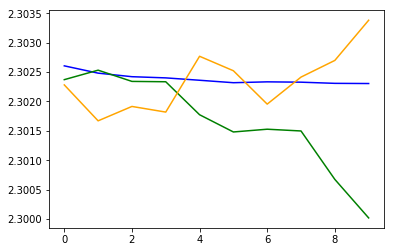

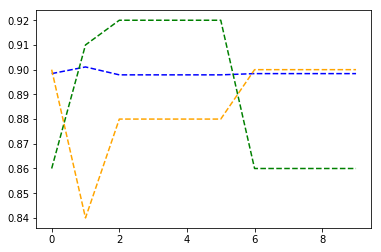

In [105]:
plot_learning_curves('errors.txt')

### Part 10

> Train your network on the Fashion MNIST dataset. Plot the training/valid/test curves (error and loss as a function of the epoch number, corresponding to what you wrote in a file in the last question). Add to your report the curves obtained using your best hyperparameters, i.e. for which you obtained your best error on the validations et. We suggest 2 plots: the first one will plot the error rate (train/valid/test with different colors, show which color in a legend) and the other one for the averaged loss (on train/valid/test). You should be able to get less than 20% test error.